# Homework 6:
Duo Xu

## Problem 2. 

Import tensorflow and other packages, load data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"


with open(tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    

In [2]:
Xbp = data_tr['bp_coef']
Xrp = data_tr['rp_coef']

xbp = np.zeros((4000, 8))
xrp = np.zeros((4000, 8))
x = np.zeros((4000, 16))
for i in range(len(xbp)):
    xbp[i] = Xbp[i][:8]/Xrp[i][0]
    xrp[i] = Xrp[i][:8]/Xrp[i][0]
    x[i] = np.append(xbp[i],xrp[i])

Y = data_tr['labels'][:,0]

Build deep neural network with 2 hidden layers of size 64 and output layer of size 1 (one value of $T_{eff}$).

In [3]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [4]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(x))

In [5]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16)               33        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,346
Trainable params: 5,313
Non-trainable params: 33
_________________________________________________________________


In [6]:
history = dnn_model.fit(
    x,
    Y,
    validation_split=0.2,
    verbose=0, epochs=100)

In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

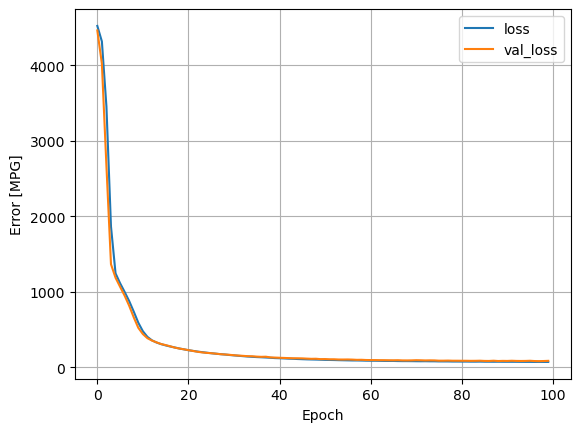

In [8]:
plot_loss(history)

In [9]:
Xbpv = data_val['bp_coef']
Xrpv = data_val['rp_coef']

xbpv = np.zeros((1000, 8))
xrpv = np.zeros((1000, 8))
xv = np.zeros((1000, 16))
for i in range(len(xbpv)):
    xbpv[i] = Xbpv[i][:8]/Xrpv[i][0]
    xrpv[i] = Xrpv[i][:8]/Xrpv[i][0]
    xv[i] = np.append(xbpv[i],xrpv[i])

test_predictions = dnn_model.predict(xv).flatten()

32/32 [==============================] - 0s 404us/step


,Mean absolute error [MPG]
dnn_model,80.193031
linear_regression_model,110.086692


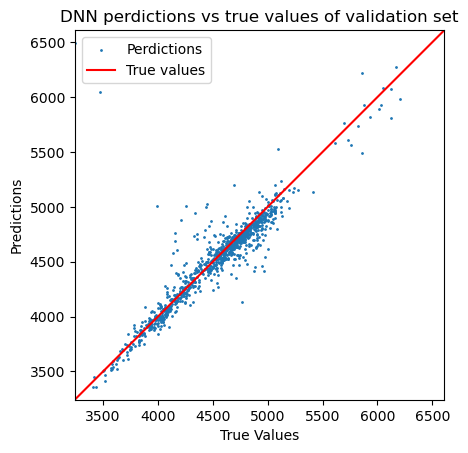

In [10]:
a = plt.axes(aspect='equal')
plt.scatter(data_val['labels'][:,0], test_predictions, s=1, label = 'Perdictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [min(data_val['labels'][:,0]), max(data_val['labels'][:,0])]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, color = 'r', label = 'True values')
plt.legend()
plt.title('DNN perdictions vs true values of validation set')

test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(xv, data_val['labels'][:,0], verbose=0)

XTX = np.matmul(np.transpose(x),x)
XY = np.matmul(np.transpose(x), data_tr['labels'][:,0])
thetahat = np.linalg.solve(XTX, XY)

linear_regression_results = (1/len(data_val['labels'][:,0])) * sum(abs(data_val['labels'][:,0] - np.matmul(xv, thetahat)))
test_results['linear_regression_model'] = linear_regression_results
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T